
BloomTech Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- Make at least 1 partial dependence plot to explain your model.
- Make at least 1 Shapley force plot to explain an individual prediction.

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset.

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- Make multiple PDPs with 1 feature in isolation.
- Make multiple PDPs with 2 features in interaction. 
- Use Plotly to make a 3D PDP.
- Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- Use Shapley values to display verbal explanations of individual predictions.
- Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
# Import Libraries, Dataset

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from category_encoders import OrdinalEncoder, OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE, SMOTENC # to fix imbalance data
from imblearn.pipeline import make_pipeline as imblearn_pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.inspection import permutation_importance 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

# Path to dataset
DATA_PATH = '/Users/Yanin/Documents/BloomTech/Course/Sprint7/datasets/loan_data.csv'

# I. Wrangle Data

In [2]:
 def wrangle(filepath):
    loans = pd.read_csv(filepath)
    
    # Replacing period in column names with underscore
    loans.columns = loans.columns.str.replace(".", "_")
    
    # Set data type of 'purpose' column as category
    loans['purpose'] = loans['purpose'].astype('category')
    
    # Outliers - Finding the upper and lower bounds for the log_annual_inc feature
    def find_outlier_limits(col_name):
        Q1,Q3=loans[col_name].quantile([.25,.75])
        IQR=Q3-Q1
        low=Q1-(1.5* IQR)
        high=Q3+(1.5* IQR)
        return (high,low)

    high_log_annual_inc, low_log_annual_inc = find_outlier_limits('log_annual_inc')

    # Replacing outlier values for log_annual_inc, and installment with respective upper and lower limits 
    loans.loc[loans['log_annual_inc'] > high_log_annual_inc,'log_annual_inc'] = high_log_annual_inc
    loans.loc[loans['log_annual_inc'] < low_log_annual_inc,'log_annual_inc'] = low_log_annual_inc
    
    # Feature Engineering
    loans['cred_score'] = loans['fico'].apply(lambda x: 0 if x < 670 else 1)
    loans['financially_responsible'] = loans['delinq_2yrs'].apply(lambda x: 0 if x > 2 else 1)
    loans['credit_hist'] = loans['days_with_cr_line'].apply(lambda x: 0 if x < 1096 else 1)
    loans['multiple_hard_inq'] = loans['inq_last_6mths'].apply(lambda x: 0 if x<=1 else 1)
    loans['cred_util_rate'] = loans['revol_util'].apply(lambda x: 1 if (x>30 or x==0) else 0)
    
    # To avoid data leakage let's drop the columns used to do feature engineering
    loans.drop(columns=['fico', 'delinq_2yrs', 'days_with_cr_line', 'inq_last_6mths', 'revol_util'], inplace=True)
    
    return loans

In [3]:
# Read loans data
loans = wrangle(DATA_PATH)

# Check shape of data set and first 5 rows
display(loans.shape)
loans.head()

(9578, 14)

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,revol_bal,pub_rec,not_fully_paid,cred_score,financially_responsible,credit_hist,multiple_hard_inq,cred_util_rate
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,28854,0,0,1,1,1,0,1
1,1,credit_card,0.1071,228.22,11.082143,14.29,33623,0,0,1,1,1,0,1
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,3511,0,0,1,1,1,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,33667,0,0,1,1,1,0,1
4,1,credit_card,0.1426,102.92,11.299732,14.97,4740,0,0,0,1,1,0,1


## II. Split Data

In [4]:
# Split data into feature matrix and target vector
target = 'not_fully_paid'

y = loans[target] # target vector
X = loans.drop(columns=target) # feature matrix

In [5]:
# Randomly split data into remain and test sets
X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [6]:
# Create a training set and validation set from the remaining data
X_train, X_val, y_train, y_val = train_test_split(X_remain, y_remain, test_size= 0.2, random_state = 42)

In [8]:
# Balance the classes in the target vector
# method = SMOTE(random_state=42)
method = SMOTENC(random_state=42, categorical_features= [1,2])
X_train_bal, y_train_bal = method.fit_resample(X_train, y_train)

In [9]:
# Ordinal Encode categorical values (without using pipelines)
oe = OrdinalEncoder()
oe.fit(X_train)
XT_train = oe.transform(X_train_bal)
XT_val = oe.transform(X_val)
XT_test = oe.transform(X_test)

# III. Establish Baseline

In [10]:
print('Baseline accuracy - imb data:', y_train.value_counts(normalize=True).max())

Baseline accuracy - imb data: 0.8350465002447381


In [17]:
print('Baseline accuracy - resampled data:', y_train_bal.value_counts(normalize=True).max())

Baseline accuracy - resampled data: 0.5


# IV. Build Model

In [11]:
# Not using any pipeline
model_rf = RandomForestClassifier(random_state=42, max_depth=27, min_samples_leaf=1, n_estimators=74, n_jobs=-1)
model_xgb = XGBClassifier(random_state=42, max_depth=27, n_estimators=150, scale_pos_weight=93, n_jobs=-1)

In [16]:
model_rf.fit(XT_train, y_train_bal);
model_xgb.fit(XT_train, y_train_bal);

# V. Check Metrics

In [19]:
print('Training Accuracy RF:', model_rf.score(XT_train, y_train_bal))
print('Validation Accuracy RF:', model_rf.score(XT_val, y_val))

Training Accuracy RF: 1.0
Validation Accuracy RF: 0.7423352902804957


In [20]:
print('Training Accuracy XGBOOST:', model_xgb.score(XT_train, y_train_bal))
print('Validation Accuracy XGBOOST:', model_xgb.score(XT_val, y_val))

Training Accuracy XGBOOST: 1.0
Validation Accuracy XGBOOST: 0.6405740378343118


### Classification Report - Precision, Recall, f-1 score

Random Forest Classifier
              precision    recall  f1-score   support

           0       0.87      0.82      0.85      1316
           1       0.20      0.28      0.23       217

    accuracy                           0.74      1533
   macro avg       0.54      0.55      0.54      1533
weighted avg       0.78      0.74      0.76      1533



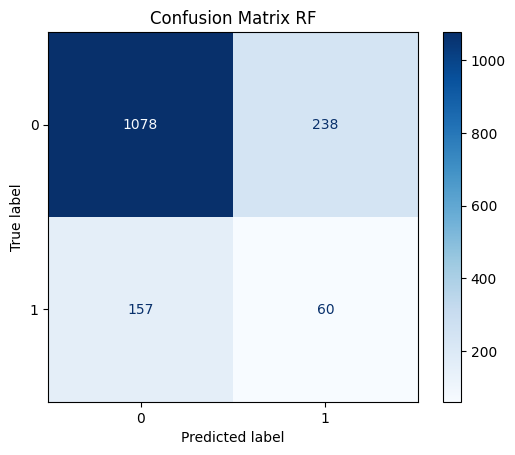

In [22]:
print('Random Forest Classifier')
print(classification_report(y_val, model_rf.predict(XT_val)));
plot_confusion_matrix(model_rf, XT_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix RF');

Extreme Gradient Boosting
              precision    recall  f1-score   support

           0       0.87      0.68      0.77      1316
           1       0.17      0.39      0.23       217

    accuracy                           0.64      1533
   macro avg       0.52      0.53      0.50      1533
weighted avg       0.77      0.64      0.69      1533



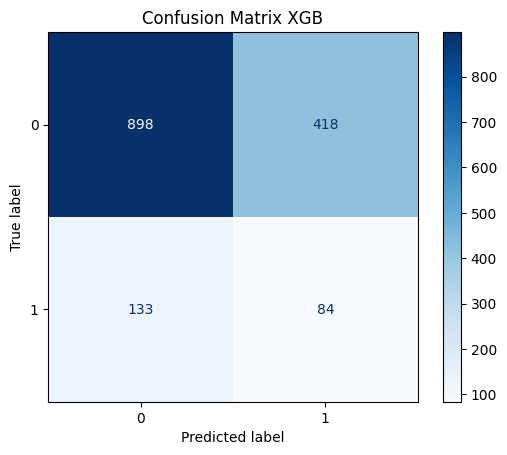

In [23]:
print('Extreme Gradient Boosting')
print(classification_report(y_val, model_xgb.predict(XT_val)));
plot_confusion_matrix(model_xgb, XT_val, y_val, cmap=plt.cm.Blues)
plt.title('Confusion Matrix XGB');

# VI. Communicate Results

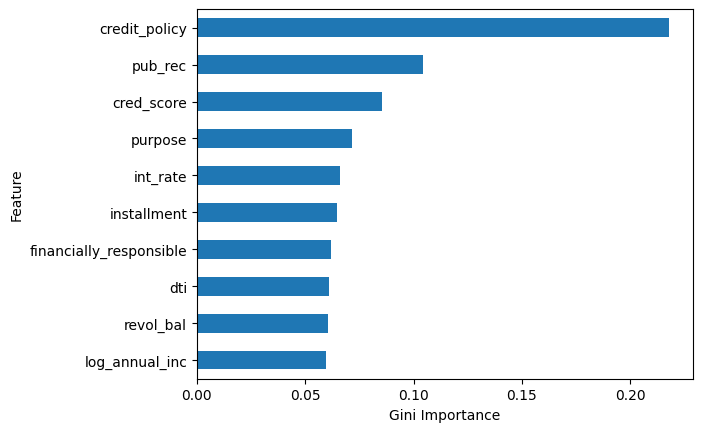

In [28]:
# Plot feature importances for XGboost Model - Best performing model in terms of recall

importances = model_xgb.feature_importances_
feature_names = oe.get_feature_names()
feat_imp= pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature');

In [26]:
# Permutation Importances for the Best Performing Model in terms of Recall
perm_imp= permutation_importance(model_xgb, XT_val, y_val, random_state=42)
data_perm = {'imp_mean':perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}
df_perm = pd.DataFrame(data_perm, index=XT_val.columns).sort_values('imp_mean')
df_perm

,imp_mean,imp_std
log_annual_inc,-3.052838e-02,0.005176
revol_bal,-2.818004e-02,0.007043
dti,-2.061318e-02,0.008988
pub_rec,-2.087410e-03,0.001566
credit_hist,-4.440892e-17,0.000825
financially_responsible,3.913894e-04,0.000320
purpose,5.218526e-04,0.004393
multiple_hard_inq,5.609915e-03,0.007021
installment,1.095890e-02,0.007006
cred_util_rate,1.539465e-02,0.003104


### PDP Interact Plot

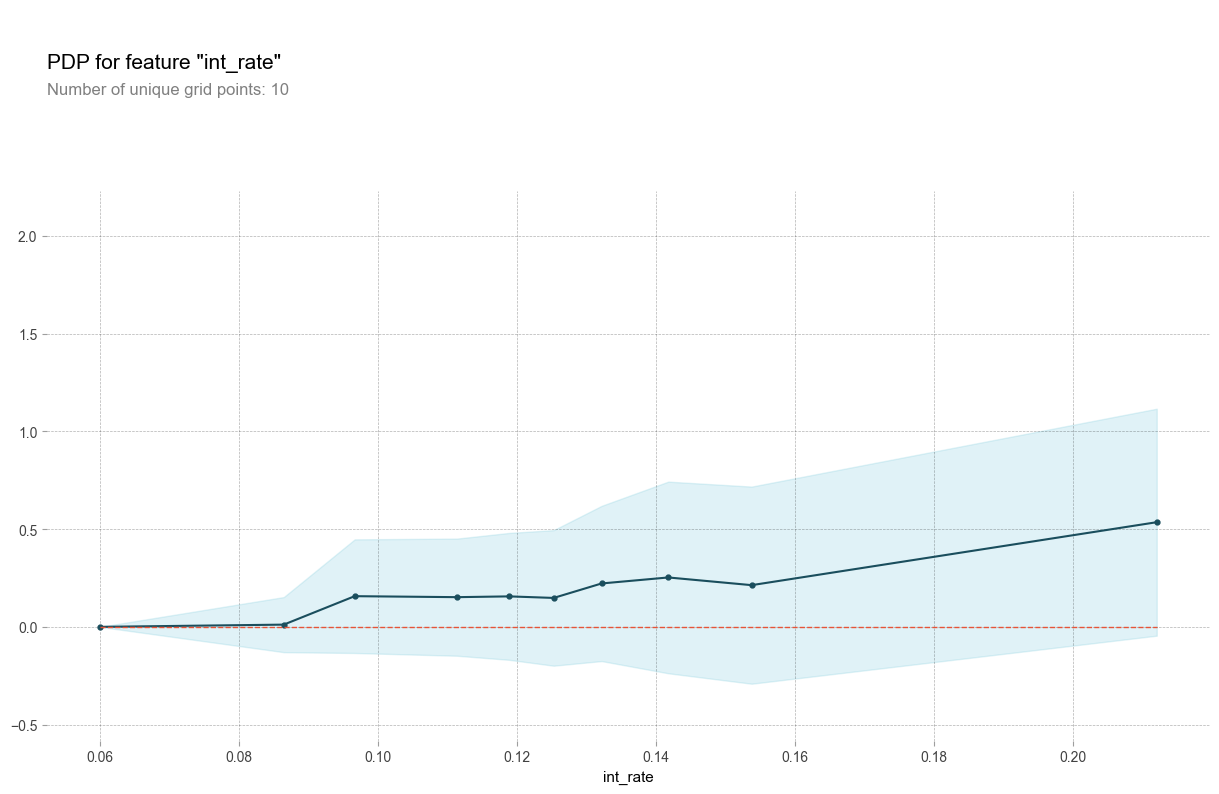

In [39]:
# One Feature in Isolation

sample_feature = 'int_rate'

isolate= pdp_isolate(
    model_xgb,
    dataset = XT_val, 
    model_features = XT_val.columns,
    feature = sample_feature
)

# Plot PDP Isolate.
pdp_plot(isolate, feature_name=sample_feature);

**Insights:** 
The higher the interest rate, the greater the probability of correctly classifying the positive class (not fully paid loan).

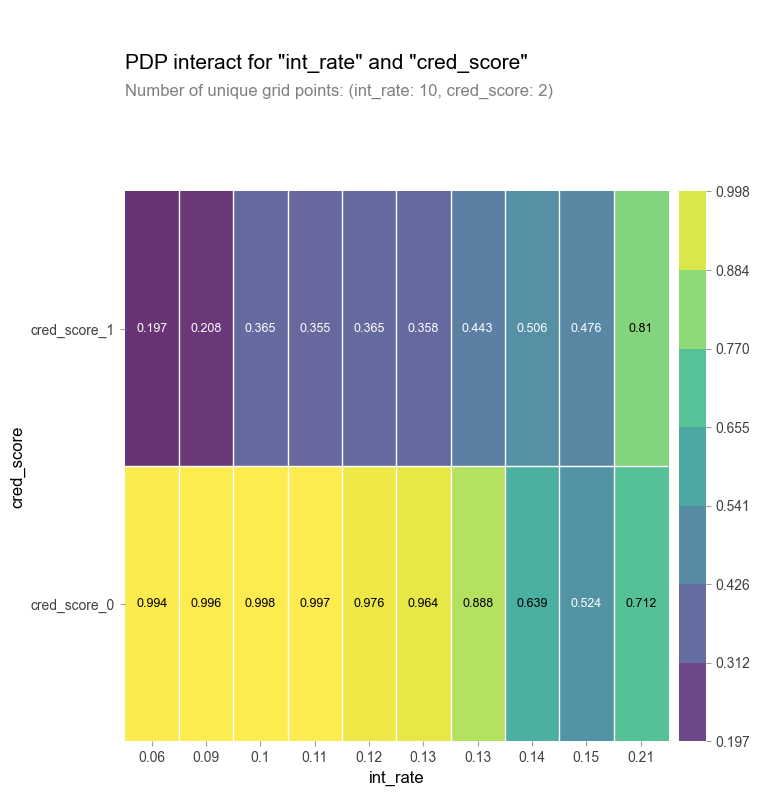

In [38]:
#select two features
two_selected_features = ['int_rate', 'cred_score'] # it could be the best features of your permutation importances

# instantiate pdp_interact class

interact = pdp_interact(
    model_xgb,
    dataset=XT_val, 
    model_features=XT_val.columns,
    features=two_selected_features
)

# Plot PDP interact plot
pdp_interact_plot(interact, feature_names=two_selected_features, plot_type='grid');

Insight: We plotted the two most relevant features, according to our fitted model. We can see that the change in color on the y-axis, which is the credit score, reflects that borrowers with preferred credit scores have less chances to being classified as possible loan defaulters by the model. Borrowers who are assigned a high interest rate might be classified as defaulters as well.

### Shapley Plot

In [51]:
# select sample

sample_row = XT_val.head(1)
sample_row

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,revol_bal,pub_rec,cred_score,financially_responsible,credit_hist,multiple_hard_inq,cred_util_rate
8261,0,2,0.1513,451.48,11.264464,29.28,61057,0,1,1,1,1,1


In [52]:
# Create an instance of TreeExplainer
explainer = shap.TreeExplainer(model_rf)  # does not like pipelines

# get shap values
shap_values = explainer.shap_values(sample_row)

shap.initjs() #initialization of java script.

# force plot
shap.force_plot(
    base_value = explainer.expected_value[0], # mean or average of your target
    shap_values=shap_values[0], 
    features=sample_row
)

Insights:
- The base value (49.95%) is the baseline or average predicted probability of classifying the loan as not fully paid.
- The number in bold (58%) is the model's prediction for that particular example. 
- The red arrow represents the features that pushed the model score higher. 
- The blue arrow represents the features that pushed the model score lower.
- The features that had the biggest influence on the score for this particular borrower were credit policy 0 which means the borrower didn't meet the underwriting criteria, and debt to income ratio under 30%.